# Text Ranking

We have a collection of medical texts (richtlijnendatabase.nl). The texts are divided in medical recommendations (*richtlijnen*), each of which contains several texts (html pages). Each text contains several paragraphs. We want to know how well the recommendations and the paragraphs match a list of keywords.

In [1]:
import csv
import datetime
import json
import math
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import przona
import random
import re
import sys
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore

In [2]:
CSV_DIR = "csv/"

csv.field_size_limit(sys.maxsize)
paragraphs = przona.read_dict(CSV_DIR+"paragraphs_20210621.csv")

In [3]:
def get_url_suffixes(paragraphs):
    suffixes = {}
    i = 0
    for url in paragraphs.keys():
        if re.search("^/richtlijn/", url):
            suffix = "."+url.split(".")[-1].split("?")[0]
            if re.search("/", suffix): 
                suffix = "(folder)"
            if suffix in suffixes: suffixes[suffix] += 1
            else: suffixes[suffix] = 1
    return(suffixes)

get_url_suffixes(paragraphs)

{'.html': 9667}

We found three type of files in the folder `/richtlijn`:`.php` files, which could not be retrieved, folders (no extension) and HTML files (`.html`). We are only interested in the HTML files. Ideally the texts of the folders should be stored in index pages, which on this web site have file names including the string *startpagina*. However not all of these index pages have been retrieved. In order to avoid both duplicate texts and missing texts it seems to be best to rename all *startpagina* to folder pages, if these do not already exist, and then work with both 

In [4]:
KEYWORDS_FILE = "../data/210119 Digitale zorg - sleutelwoorden en combinaties.csv"
KEYWORDS_FILE_V2 = "../data/210119 Digitale zorg - sleutelwoorden en combinaties v2.csv"

In [5]:
def get_keywords(keywords_file):
    infile = open(keywords_file, "r")
    csvreader = csv.reader(infile)
    keywords = []
    for row in csvreader:
        if row[1].strip() == "ja":
            keywords.append(row[0].strip())
        elif row[1].strip() == "nee":
            for i in range(2, len(row)):
                if row[i].strip() != "":
                    keywords.append(row[i].strip())
    infile.close()
    return(keywords)

len(get_keywords(KEYWORDS_FILE))

111

In [6]:
def get_keywords_v2(keywords_file):
    infile = open(keywords_file, "r")
    csvreader = csv.reader(infile)
    keywords = {}
    for row in csvreader:
        if row[0].strip() != "Term":
            keywords[row[0].strip()] = row[1].strip
    infile.close()
    return(keywords)

len(get_keywords_v2(KEYWORDS_FILE_V2))

111

In [7]:
sorted(get_keywords(KEYWORDS_FILE)) == sorted(list(get_keywords_v2(KEYWORDS_FILE_V2).keys()))

True

Keyword expansion: allow keywords with spaces, like `digital care`,to be spelled without the space or with a hyphen: `digitalcare` and `digital-care`.

In [8]:
def make_new_keywords(prefix, suffix_list):
    if len(suffix_list) > 1:
        suffix_list = make_new_keywords(suffix_list[0], suffix_list[1:])
    new_keywords = []
    for suffix in suffix_list:
        new_keywords.append(prefix+suffix)
        new_keywords.append(prefix+" "+suffix)
        new_keywords.append(prefix+"-"+suffix)
    return(new_keywords)

def expand_keywords(keywords):
    keywords.extend(["e health", "e health toepassing", "e learning", "m health", 
                     "tele begeleiding", "tele consultatie", "tele health", "tele medicine", "tele monitoring"])
    for i in range(0,len(keywords)):
        keywords[i] = keywords[i].strip().lower()
    new_keywords = []
    for keyword in keywords:
        keyword_parts = keyword.split()
        if len(keyword_parts) > 1:
            for new_keyword in make_new_keywords(keyword_parts[0], keyword_parts[1:]):
                if new_keyword not in keywords and new_keyword not in new_keywords:
                    new_keywords.append(new_keyword)
    keywords.extend(new_keywords)
    return(sorted(list(set(keywords))))

In [9]:
keywords = expand_keywords(get_keywords(KEYWORDS_FILE))

In [10]:
len(keywords)

333

In [11]:
def count_words(text):
    return(len(text.strip().split()))

## 1. Finding paragraphs with keywords (skip)

In [12]:
MIN_NBR_OF_WORDS = 10

def find_matching_paragraphs(keywords, paragraphs):
    matching_urls = {}
    matching_paragraphs = []
    non_matching_paragraphs = []
    counter = 0
    for url in paragraphs:
        for paragraph in paragraphs[url]:
            if count_words(paragraph) >= MIN_NBR_OF_WORDS:
                match = ""
                for keyword in keywords:
                    if keyword in ["app", "apps"]:
                        keyword = r'\b'+keyword+r'\b'
                    if re.search("^[em] ", keyword):
                        keyword = r'\b'+keyword
                    for dummy in re.findall(keyword, paragraph, flags=re.IGNORECASE):
                        if match == "":
                            match = keyword
                        else:
                            match += "#"+keyword
                        if url in matching_urls:
                            matching_urls[url] += "#"+keyword
                        else:
                            matching_urls[url] = keyword
                if match != "":
                    matching_paragraphs.append([match, paragraph])
                else:
                    non_matching_paragraphs.append(paragraph)
        counter += 1
        przona.squeal(f"documents: {counter}; matches: {len(matching_paragraphs)}")
    return(matching_paragraphs, non_matching_paragraphs, matching_urls)

matching_paragraphs, non_matching_paragraphs, matching_urls = \
    find_matching_paragraphs(keywords, { url:paragraphs[url] for url in paragraphs.keys() if re.search("^/richtlijn/", url) })

documents: 9667; matches: 769


In [13]:
recommendations = {}
for url in matching_urls:
    recommendation = url.split("/")[2]
    if recommendation in recommendations:
        recommendations[recommendation] += "#"+matching_urls[url]
    else:
        recommendations[recommendation] = matching_urls[url]

In [14]:
len(matching_paragraphs), len(non_matching_paragraphs), len(matching_urls), len(recommendations)

(769, 652379, 465, 87)

Without keyword expansion (111 keywords), we found 1,088 matching paragraphs and 1,067,899 non-matching paragraphs.
With keyword expansion (330 keywords), we found 1,115 matching paragraphs and 1,067,872 non-matching paragraphs.

In [15]:
keywords_found = {}
for kws,p in matching_paragraphs:
    for k in kws.split("#"):
        if k in keywords_found:
            keywords_found[k] += 1
        else:
            keywords_found[k] = 1
print(len(keywords_found), {k:keywords_found[k] for k in sorted(keywords_found.keys(), key=lambda k:keywords_found[k], reverse=True)})

35 {'e-health': 229, '\\bapp\\b': 170, 'e-learning': 161, 'ehealth': 124, 'digitale vragenlijst': 40, 'mhealth': 38, 'e-health toepassing': 38, 'telemedicine': 34, '\\bapps\\b': 33, 'online vragenlijst': 26, 'domotica': 21, 'online ondersteuning': 19, '\\be health': 17, 'ehealth toepassing': 10, 'online monitoring': 9, 'teleconsultatie': 8, 'telemonitoring': 8, 'online contact': 7, 'm-health': 6, 'blended care': 4, 'digitale zorg': 4, 'telehealth': 3, 'digitale ondersteuning': 3, 'digitalezorg': 3, 'internetbehandeling': 3, 'e-health-toepassing': 3, 'internetmodule': 2, 'digitale monitoring': 2, 'elearning': 2, 'geautomatiseerde monitoring': 1, 'online screening': 1, 'internet module': 1, 'internet vragenlijst': 1, 'online module': 1, 'tele-consultatie': 1}


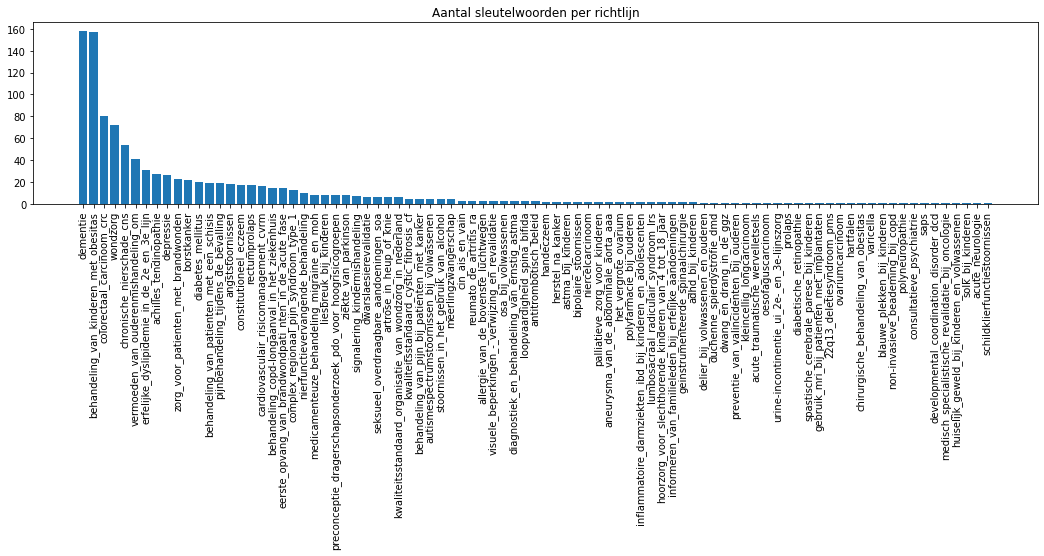

In [16]:
recommendations = {r:recommendations[r] for r in sorted(recommendations.keys(), key=lambda r:len(recommendations[r].split("#")), reverse=True)}

plt.subplots(figsize=(18,9))
plt.bar(list(recommendations.keys()), [len(recommendations[r].split('#')) for r in recommendations])
plt.xticks(rotation=90)
plt.title("Aantal sleutelwoorden per richtlijn")
plt.gcf().subplots_adjust(bottom=0.6)
plt.savefig("plot.png")
plt.show()

## 2. Comparing vocabularies (skip)

In [19]:
def count_tokens(text):
    tokens, frequencies = np.unique(word_tokenize(text), return_counts=True)
    return({tokens[i]:frequencies[i] for i in range(0, len(tokens))})

In [20]:
def ran_select(large_list, selection_size):
    if selection_size >= len(large_list):
        return(large_list)
    selected_list = []
    seen = {}
    while len(selected_list) < selection_size:
        selected_id = random.randint(0, len(large_list)-1)
        if not selected_id in seen:
            selected_list.append(large_list[selected_id])
            seen[selected_id] = True
    return(selected_list)

In [21]:
matching_tokens = count_tokens((" ".join([pair[1] for pair in matching_paragraphs])).lower())

Creating the vocabulary of the one-million non-matching paragraphs fails because of memory problems. Using a random sample worked for at most 85,000 paragraphs but allways. Perhaps changing the `count_tokens` function could solve this problem.  

In [22]:
non_matching_tokens = count_tokens((" ".join(ran_select(non_matching_paragraphs, 85000))).lower())

KeyboardInterrupt: 

In [19]:
NBROFTOKENS = "totalFreq"
NBROFTYPES = "nbrOfWords"
WORDFREQS = "wordFreqs"

def makeTscoreData(tokenList):
    data = { NBROFTOKENS:0, NBROFTYPES:0, WORDFREQS:{} }
    for token in tokenList:
        if not math.isnan(tokenList[token]):
            data[WORDFREQS][token] = tokenList[token]
            data[NBROFTYPES] += 1
            data[NBROFTOKENS] += tokenList[token]
    return(data)

def sortTscores(tscores):
    return({token:tscores[token] for token in sorted(tscores.keys(),key=lambda t:tscores[t],reverse=True)})

NBROFEXAMPLES = 20

def dictTopN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][0:n])

In [43]:
tscores_data_matching = makeTscoreData(matching_tokens)
tscores_data_non_matching = makeTscoreData(non_matching_tokens)
context_words = dictTopN(sortTscores(tscore.computeTscore(tscores_data_matching, tscores_data_non_matching)), n=500)
for x in context_words:
    print(x[1], end=" ")

e-learning e-health app lid ehealth ontwikkeld online ' een vorm vragenlijst dementie\ richtlijn afdeling bijscholingsactiviteiten richtlijntoets na- geaccrediteerde –in colorectaal maak carcinoom behoeve interventie roche dementie bruikbaarheid via – kader digitale ontwikkelaar radboudumc telemedicine toepassingen ten module applicatie https nefroloog therapy telenefrologie verwijsgedrag oogartsen huisarts relevant //gdt.gradepro.org/app/handbook/handbook.html zorgverleners 2013. aan consultatie grant zorgdomein grade en hand problem `` solving counseling consortiumlid decisionmaking innoveren mhealth plezierige windesheim zorgnetwerken adviescie nivel/trimbos \'shared lectoraat ouderenzorg evaluatieonderzoek nivel casemanagement onderzoeksgroep zou exercise toegang websites zwolle \ acute activiteiten recommendations intensieve vier ouderenmishandeling kunnen smartphones downloaden psoriasis het bleek implementatie werken 2012-2016 emrp hlt07- metrology praktijktest researcher huisar

## 3. Select best-matching paragraph (skip)

In [47]:
context_counts = []
for match,paragraph in matching_paragraphs:
    context_counts.append(0)
    for score, word in context_words:
        for dummy in re.findall(r'\b'+word+r'\b', paragraph):
            context_counts[-1] += 1

In [56]:
sorted_matching_paragraphs_context = [matching_paragraphs[i] 
                              for i in sorted(range(0,len(matching_paragraphs)), key=lambda i:context_counts[i], reverse=True)]
sorted_context_counts = [context_counts[i] 
                              for i in sorted(range(0,len(matching_paragraphs)), key=lambda i:context_counts[i], reverse=True)]

In [76]:
sorted_matching_paragraphs_context[0],sorted_context_counts[0]

(['e-learning#e-learning',
  'In een RCT (Trivalle, 2010) werd het effect van een educatieve interventie op het aantal vermijdbare ADE’s bij ouderen opgenomen in het ziekenhuis. Gedurende één week kregen de behandelteams op de interventie afdelingen onderwijs over het voorschrijven aan oudere patiënten (onder andere hoe om te gaan met risico medicatie zoals antipsychotica, benzodiazepines, NSAIDs, en over dosisaanpassingen bij verminderde nierfunctie), ADE’s incidentie en interventie strategieën. Het aantal ADE’s werd met 14% gereduceerd. In een before-and-after studie van Lutters (2004) werd een onderwijsprogramma bestaande uit distributie van richtlijnen over urineweg en luchtweginfecties en colleges over geriatrische infectieziekten gecombineerd met een wekelijkse audit-en-feedback waarbij voor patiënten met verdenking op infectie gerichte individuele begeleiding bij het stellen van diagnose en kiezen van antibiotica aan de voorschrijver werd geboden. Deze interventie resulteerde in

In [62]:
sorted_matching_paragraphs_keywords = [m for m in sorted(matching_paragraphs, key=lambda m:len(m[0].split("#")), reverse=True)]

In [77]:
sorted_matching_paragraphs_keywords[1]

['digitale ondersteuning#digitale zorg#ehealth#ehealth#ehealth#ehealth#ehealth toepassing',
 'De positieve effecten van beeldschermzorg op de kosten zijn in de gezondheidszorg tot dusverre nog niet overtuigend bewezen. Dit geldt ook voor een GLI behandeling met beeldschermzorg. Het toepassen van eHealth wordt door de overheid gezien als mogelijkheid om de kosten van de gezondheidszorg te verminderen. De kosten van eHealth en mHealth zijn niet eenduidig. EHealth toepassingen bovenop reguliere zorg kan extra kosten met zich meebrengen. Het implementeren van digitale zorg in de werkwijze van zorgverleners kost tijd en geld. Ook is er digitale ondersteuning nodig voor de zorggebruikers qua vaardigheid en middelen. Tenslotte zijn er ontwikkel- en jaarlijkse licentiekosten van de verschillende eHealth-platformleveranciers.']

/richtlijn/behandeling_van_kinderen_met_obesitas/ehealth_mhealth_bij_gli.html

## 4. Storing exemplatory paragraphs in JSON and HTML

In [17]:
RECOMMENDATION = "richtlijn"
RECOMMENDATIONS = "richtlijnen"
KEYWORDS = "sleuteltermen"
TERM_COUNT = "aantal gevonden sleuteltermen"
TOKEN_COUNT = "aantal tokens"
TYPE_COUNT = "aantal types"
DOCUMENTS = "documenten"
DOCUMENT = "document"
PARAGRAPH = "paragraaf"
PARAGRAPHS = "paragrafen"
BESTPARAGRAPH = "exemplarische paragraaf"

In [18]:
MIN_NBR_OF_WORDS = 10

def remove_duplicates(matches, queries):
    parts = []
    wholes = []
    for i in range(0, len(matches)):
        for j in range(0, len(matches)):
            if len(matches[i]) > len(matches[j]) and matches[i].startswith(matches[j]) and j not in parts and i not in wholes:
                parts.append(j)
                wholes.append(i)
    for part in [p for p in sorted(parts, reverse=True)]:
        del(matches[part])
        del(queries[part])
    return(matches, queries)

def find_matching_paragraphs(keywords, paragraphs):
    matching_paragraphs = []
    counter = 0
    for url in paragraphs:
        for paragraph in paragraphs[url]:
            if count_words(paragraph) >= MIN_NBR_OF_WORDS:
                matches = []
                queries = []
                for keyword in keywords:
                    if keyword in ["app", "apps"]:
                        keyword = r'\b'+keyword+r'\b'
                    if re.search("^[em] ", keyword):
                        keyword = r'\b'+keyword
                    for match in re.findall(keyword, url + " " + paragraph, flags=re.IGNORECASE):
                        matches.append(match)
                        queries.append(keyword)
                if len(matches) > 0:
                    matches, queries = remove_duplicates(matches, queries)
                    matching_paragraphs.append({"url": url, "matches": matches, "queries": queries, "paragraph": paragraph})
        counter += 1
        przona.squeal(f"documents: {counter}; matches: {len(matching_paragraphs)}")
    return(matching_paragraphs)

matching_paragraphs = find_matching_paragraphs(keywords, { url:paragraphs[url] for url in paragraphs.keys() if re.search("^/richtlijn", url) })

documents: 9667; matches: 1240


In [19]:
def make_bold(text_in, queries, matches, keyword=None):
    text_out = text_in
    seen = {}
    if keyword == None:
        selected_matches = matches
        selected_queries = queries
    else:
        selected_matches = [matches[i] for i in range(0, len(matches)) if normalize_keyword(matches[i]) == normalize_keyword(keyword)]
        selected_queries = [queries[i] for i in range(0, len(matches)) if normalize_keyword(matches[i]) == normalize_keyword(keyword)]     
    matches_by_length = [selected_matches[i] for i in sorted(range(0, len(selected_matches)), key=lambda i:len(selected_matches[i]), reverse=True)]
    queries_by_length = [selected_queries[i] for i in sorted(range(0, len(selected_matches)), key=lambda i:len(selected_matches[i]), reverse=True)]
    for i in range(0, len(matches_by_length)):
        if queries_by_length[i] not in seen:
            text_out = re.sub("("+queries_by_length[i]+")", "<strong>"+r'\1'+"</strong>", text_out, flags=re.IGNORECASE)
            seen[queries_by_length[i]] = matches_by_length[i].lower()
        elif seen[queries_by_length[i]] != matches_by_length[i].lower():
            print(f"warning: make_bold: replacement problem: {seen[queries_by_length[i]]} vs {matches_by_length[i]}")
    return(text_out)

In [20]:
def update_best_paragraph(best_paragraph, new_paragraph, keyword=None):
    if keyword != None:
        matches = [k for k in new_paragraph["matches"] if k == keyword]
    else:
        matches = new_paragraph["matches"]
    count = len(matches)
    if TERM_COUNT not in best_paragraph or count > best_paragraph[TERM_COUNT]:
        best_paragraph[TERM_COUNT] = count
        best_paragraph[RECOMMENDATION] = make_bold(new_paragraph["url"].split("/")[2], new_paragraph["queries"], new_paragraph["matches"], keyword=keyword)
        best_paragraph[DOCUMENT] = make_bold("/".join(new_paragraph["url"].split("/")[3:]), new_paragraph["queries"], new_paragraph["matches"], keyword=keyword)
        best_paragraph[PARAGRAPH] = make_bold(new_paragraph["paragraph"], new_paragraph["queries"], new_paragraph["matches"], keyword=keyword)
        best_paragraph[KEYWORDS] = " | ".join(matches)
    return(best_paragraph)

In [21]:
def normalize_keyword(keyword):
    return(re.sub("[ -]", "", keyword.lower()))

In [22]:
def sort_and_label(dictionary):
    return({f"({dictionary[key][TERM_COUNT]}) {key}":dictionary[key] 
            for key in sorted(dictionary, key=lambda k:dictionary[k][TERM_COUNT], reverse=True)})

In [23]:
def make_paragraph_number(number=None):
    if number == None:
        return(0)
    return(number+1)

In [24]:
len(matching_paragraphs)

1240

In [25]:
summary_data = { TERM_COUNT: 0, TOKEN_COUNT:0, TYPE_COUNT:0, BESTPARAGRAPH: {}, RECOMMENDATIONS: {}, KEYWORDS: {} }
last_par = make_paragraph_number()
for paragraph_data in matching_paragraphs:
    url = paragraph_data["url"]
    recommendation = url.split("/")[2]
    filename = "/".join(url.split("/")[3:])
    paragraph = make_bold(url+" "+paragraph_data["paragraph"], paragraph_data["queries"], paragraph_data["matches"])
    count_all_matches = len(paragraph_data["matches"])
    summary_data[TERM_COUNT] += count_all_matches
    summary_data[BESTPARAGRAPH] = update_best_paragraph(summary_data[BESTPARAGRAPH], paragraph_data)
    
    if recommendation not in summary_data[RECOMMENDATIONS]:
        summary_data[RECOMMENDATIONS][recommendation] = { TERM_COUNT: 0,
                                                          TOKEN_COUNT: 0,
                                                          TYPE_COUNT: 0,
                                                          BESTPARAGRAPH: {},
                                                          KEYWORDS: {},
                                                          DOCUMENTS: {}
                                                        }
    summary_data[RECOMMENDATIONS][recommendation][TERM_COUNT] += count_all_matches
    summary_data[RECOMMENDATIONS][recommendation][BESTPARAGRAPH] = \
        update_best_paragraph(summary_data[RECOMMENDATIONS][recommendation][BESTPARAGRAPH], paragraph_data)
    if filename not in summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS]:
        summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS][filename] = { TERM_COUNT: 0, TOKEN_COUNT: 0, TYPE_COUNT: 0, PARAGRAPHS: {} }
    summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS][filename][TERM_COUNT] += count_all_matches
    last_par = make_paragraph_number(last_par)
    summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS][filename][PARAGRAPHS]["PAR"+str(last_par)] = \
        { TERM_COUNT: count_all_matches, PARAGRAPH: paragraph }

    seen = {}
    for i in range(0, len(paragraph_data["queries"])):
        if paragraph_data["queries"][i] in seen:
            continue
        seen[paragraph_data["queries"][i]] = True
        keyword = paragraph_data["matches"][i]
        matches = [k for k in paragraph_data["matches"] if k == keyword]
        count = len(matches)
        normalized_keyword = normalize_keyword(keyword)
        paragraph = make_bold(paragraph_data["paragraph"], 
                              [ paragraph_data["queries"][i] 
                                               for i in range(0, len(paragraph_data["matches"])) 
                                               if paragraph_data["matches"][i] == keyword ], 
                              [ paragraph_data["matches"][i] 
                                               for i in range(0, len(paragraph_data["matches"])) 
                                               if paragraph_data["matches"][i] == keyword ])

        if normalized_keyword not in summary_data[KEYWORDS]:
            summary_data[KEYWORDS][normalized_keyword] = { TERM_COUNT: 0,
                                                           BESTPARAGRAPH: {},
                                                           RECOMMENDATIONS: {}
                                                         }
        summary_data[KEYWORDS][normalized_keyword][TERM_COUNT] += count
        summary_data[KEYWORDS][normalized_keyword][BESTPARAGRAPH] = \
            update_best_paragraph(summary_data[KEYWORDS][normalized_keyword][BESTPARAGRAPH], paragraph_data, keyword=keyword)
        if recommendation not in summary_data[KEYWORDS][normalized_keyword][RECOMMENDATIONS]:
            summary_data[KEYWORDS][normalized_keyword][RECOMMENDATIONS][recommendation] = { TERM_COUNT: 0, TOKEN_COUNT: 0, TYPE_COUNT: 0, DOCUMENTS: {} }
        summary_data[KEYWORDS][normalized_keyword][RECOMMENDATIONS][recommendation][TERM_COUNT] += count
        if filename not in summary_data[KEYWORDS][normalized_keyword][RECOMMENDATIONS][recommendation][DOCUMENTS]:
            summary_data[KEYWORDS][normalized_keyword][RECOMMENDATIONS][recommendation][DOCUMENTS][filename] = { TERM_COUNT: 0, TOKEN_COUNT: 0, TYPE_COUNT: 0, PARAGRAPHS: {} }
        summary_data[KEYWORDS][normalized_keyword][RECOMMENDATIONS][recommendation][DOCUMENTS][filename][TERM_COUNT] += count
        summary_data[KEYWORDS][normalized_keyword][RECOMMENDATIONS][recommendation][DOCUMENTS][filename][PARAGRAPHS]["PAR"+str(last_par)] = \
            { TERM_COUNT: count, DOCUMENT: make_bold(filename, paragraph_data["queries"], paragraph_data["matches"], keyword), PARAGRAPH: paragraph }
        
        if normalized_keyword not in summary_data[RECOMMENDATIONS][recommendation][KEYWORDS]:
            summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][normalized_keyword] = { TERM_COUNT: 0, DOCUMENTS: {} }
        summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][normalized_keyword][TERM_COUNT] += count
        if filename not in summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][normalized_keyword][DOCUMENTS]:
            summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][normalized_keyword][DOCUMENTS][filename] = { TERM_COUNT: 0, TOKEN_COUNT: 0, TYPE_COUNT: 0, PARAGRAPHS: {} }
        summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][normalized_keyword][DOCUMENTS][filename][TERM_COUNT] += count
        summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][normalized_keyword][DOCUMENTS][filename][PARAGRAPHS]["PAR"+str(last_par)] = \
            { TERM_COUNT: count, DOCUMENT: make_bold(filename, paragraph_data["queries"], paragraph_data["matches"], keyword), PARAGRAPH: paragraph }

In [26]:
def cleanup_paragraph(paragraph_in):
    paragraph_out = []
    stop_words = stopwords.words('dutch')
    for token in paragraph_in.lower().split():
        if re.search(r"^[-a-zÞ-ÿ']+$", token) and token not in stop_words:
            paragraph_out.append(token)
    return(" ".join(paragraph_out))

In [27]:
counter = 0
token_set_all = set()
recommendation_data = {}
for url in paragraphs:
    if re.search("^/richtlijn", url):
        przona.squeal(counter)
        counter += 1
        token_count = 0
        token_set = set()
        for paragraph in paragraphs[url]:
            paragraph = cleanup_paragraph(paragraph)
            token_count += len(paragraph.split())
            token_set = token_set.union(set(paragraph.lower().split()))
        summary_data[TOKEN_COUNT] += token_count
        token_set_all = token_set_all.union(token_set)
        recommendation = url.split("/")[2]
        filename = "/".join(url.split("/")[3:])
        if recommendation not in recommendation_data:
            recommendation_data[recommendation] = { TOKEN_COUNT: 0, TYPE_COUNT: 0 }
        recommendation_data[recommendation][TOKEN_COUNT] += token_count
        recommendation_data[recommendation][TYPE_COUNT] += len(token_set)
        if recommendation in summary_data[RECOMMENDATIONS]:
            if filename in summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS]:
                summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS][filename][TOKEN_COUNT] = token_count
                summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS][filename][TYPE_COUNT] = len(token_set)
                for keyword in summary_data[KEYWORDS].keys():
                    if recommendation in summary_data[KEYWORDS][keyword][RECOMMENDATIONS]:
                        if filename in summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS]:
                            summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS][filename][TOKEN_COUNT] = token_count
                            summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS][filename][TYPE_COUNT] = len(token_set)
summary_data[TYPE_COUNT] += len(token_set_all)
for recommendation in recommendation_data:
    if recommendation in summary_data[RECOMMENDATIONS]:
        summary_data[RECOMMENDATIONS][recommendation][TOKEN_COUNT] = recommendation_data[recommendation][TOKEN_COUNT]
        summary_data[RECOMMENDATIONS][recommendation][TYPE_COUNT] = recommendation_data[recommendation][TYPE_COUNT]
    for keyword in summary_data[KEYWORDS].keys():
        if recommendation in summary_data[KEYWORDS][keyword][RECOMMENDATIONS]:
            summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][TOKEN_COUNT] = recommendation_data[recommendation][TOKEN_COUNT]
            summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][TYPE_COUNT] = recommendation_data[recommendation][TYPE_COUNT]

9666


In [28]:
summary_data[RECOMMENDATIONS] = sort_and_label(summary_data[RECOMMENDATIONS])
summary_data[KEYWORDS] = sort_and_label(summary_data[KEYWORDS])
for recommendation in summary_data[RECOMMENDATIONS]:
    summary_data[RECOMMENDATIONS][recommendation][KEYWORDS] = sort_and_label(summary_data[RECOMMENDATIONS][recommendation][KEYWORDS])
    for keyword in summary_data[RECOMMENDATIONS][recommendation][KEYWORDS]:
        summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][keyword][DOCUMENTS] = \
            sort_and_label(summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][keyword][DOCUMENTS])
        for url in summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][keyword][DOCUMENTS]:
            summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][keyword][DOCUMENTS][url][PARAGRAPHS] = \
                sort_and_label(summary_data[RECOMMENDATIONS][recommendation][KEYWORDS][keyword][DOCUMENTS][url][PARAGRAPHS])
    summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS] = sort_and_label(summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS])
    for filename in summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS]:
        summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS][filename][PARAGRAPHS] = \
            sort_and_label(summary_data[RECOMMENDATIONS][recommendation][DOCUMENTS][filename][PARAGRAPHS])
for keyword in summary_data[KEYWORDS]:
    summary_data[KEYWORDS][keyword][RECOMMENDATIONS] = sort_and_label(summary_data[KEYWORDS][keyword][RECOMMENDATIONS])
    for recommendation in summary_data[KEYWORDS][keyword][RECOMMENDATIONS]:
        summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS] = \
            sort_and_label(summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS])
        for url in summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS]:
            summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS][url][PARAGRAPHS] = \
                sort_and_label(summary_data[KEYWORDS][keyword][RECOMMENDATIONS][recommendation][DOCUMENTS][url][PARAGRAPHS])

In [29]:
def make_large_number_readable(number_in):
    number_in = str(number_in)
    number_out = ""
    for i in range(1, 1+len(number_in)):
        number_out = number_in[-i] + number_out
        if i % 3 == 0 and i < len(number_in):
            number_out = "." + number_out
    return(number_out)

In [30]:
def make_large_numbers_readable(dict_):
    for key in dict_:
        if isinstance(dict_[key], int):
            dict_[key] = make_large_number_readable(dict_[key])
        elif isinstance(dict_[key], dict):
            dict_[key] = make_large_numbers_readable(dict_[key])
    return(dict_)

In [31]:
summary_data = make_large_numbers_readable(summary_data)

In [32]:
out_file = open("paragraphs.json", "w")
print(json.dumps(summary_data), file=out_file)
out_file.close()

In [33]:
def json2html(data, outfile, top=False, counter=0):
    if type(data) != dict:
        print(f"<font style=\"color:grey;\">{data}</font>", file=outfile)
    else:
        if top:
            print(f"<div id=\"div{counter}\" style=\"display:block\">\n<ul>", file=outfile)
        else:
            print(f"<a href=\"javascript:toggle('div{counter}')\" id=\"div{counter}link\">open</a>", file=outfile)
            print(f"<div id=\"div{counter}\" style=\"display:none\">\n<ul>", file=outfile)
        for key in data:
            print("<li>", key, ":", file=outfile)
            counter += 1
            counter = json2html(data[key], outfile, counter=counter)
            print("</li>", file=outfile)
        print("</ul>\n</div>", file=outfile)
    return(counter)

title = "analyse richtlijnendatabase.nl"
date = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d %H:%M:%S")
outfile = open("index.html", "w")
print(f"<html>\n<head>\n<meta charset=\"utf-8\"/>\n<title>{title}</title>\n<script type=\"text/javascript\">", file=outfile)
print("function toggle(divid) {\nvar item=document.getElementById(divid); if (item) { item.style.display=(item.style.display=='none')?'block':'none'; }\n"
      "var itemlink=document.getElementById(divid+'link'); if (itemlink) { itemlink.text=(itemlink.text=='open')?'sluit':'open'; }}", file=outfile)
print(f"</script>\n</head>\n<body><p>Generated at {date}</p><h2>{title}</h2>", file=outfile)
json2html(summary_data, outfile, top=True)
print("</body>\n</html>", file=outfile)
outfile.close()